All methods require user authorization. Register the app at your [dashboard](https://developer.spotify.com/dashboard) to get the credentials. When creating the app, select "Web API" and set `http://localhost:8888/callback` as "Redirect URI" (as suggested in a [video](https://youtu.be/3RGm4jALukM) in the Spotipy [documentation](https://spotipy.readthedocs.io)). Then, before running the notebook, set the environment variables of the credentials (client ID and client secret) in your terminal:

* `export SPOTIPY_CLIENT_ID=`...
* `export SPOTIPY_CLIENT_SECRET=`...

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

Tracks are obtained from playlists of different genres. You can get the ID of a playlist from its URL. Some of the genres are:

* [pop](https://open.spotify.com/genre/0JQ5DAqbMKFEC4WFtoNRpw)
* [blues](https://open.spotify.com/genre/0JQ5DAqbMKFQiK2EHwyjcU)
* [country](https://open.spotify.com/genre/0JQ5DAqbMKFKLfwjuJMoNC)
* [rock](https://open.spotify.com/genre/0JQ5DAqbMKFDXXwE9BDJAr)
* [classical](https://open.spotify.com/genre/0JQ5DAqbMKFPrEiAOxgac3)
* [reggae](https://open.spotify.com/genre/0JQ5DAqbMKFJKoGyUMo2hE)
* [disco](https://open.spotify.com/genre/0JQ5DAqbMKFwT0m6BbKvGP) (it was under Dance/Electronic)
* [hiphop](https://open.spotify.com/genre/0JQ5DAqbMKFQ00XGBls6ym)
* [jazz](https://open.spotify.com/genre/0JQ5DAqbMKFAJ5xb0fwo9m)
* [metal](https://open.spotify.com/genre/0JQ5DAqbMKFDkd668ypn6O)

You can search for more genres in [Spotify](https://open.spotify.com/search)

In [2]:
playlists = { #TODO re-choose them with some criteria
    'pop': ['37i9dQZF1DX6wfQutivYYr', '37i9dQZF1DX01NP73ErE8b'],
    'blues': ['37i9dQZF1DXd9rSDyQguIk', '37i9dQZF1DXcu3QLJudo4X'],
    'country': ['37i9dQZF1DWZBCPUIUs2iR', '37i9dQZF1DWTkxQvqMy4WW'],
    'rock': ['37i9dQZF1DWViUlcvfltyZ', '37i9dQZF1DWW9tK1GiTdMf'],
    'classical': ['37i9dQZF1DWWEJlAGA9gs0', '37i9dQZF1DWV0gynK7G6pD'],
    'reggae': ['37i9dQZF1DWSiyIBdVQrkk', '37i9dQZF1DXbSbnqxMTGx9'],
    'disco': ['37i9dQZF1DX3jWba5xiDhV', '37i9dQZF1DX1MUPbVKMgJE'],
    'hiphop': ['37i9dQZF1DX14EWeH2Pwf3', '37i9dQZF1DWYQKKZPHGppf'],
    'jazz': ['37i9dQZF1DX30D074EWuy7', '37i9dQZF1DX55mNLGdHona'],
    'metal': ['37i9dQZF1DWWOaP4H0w5b0', '37i9dQZF1DXe6bgV3TmZOL']}

In [3]:
from contextlib import suppress

#get features
features_ = []
for genre, playlists_ in playlists.items():
    for playlist in playlists_:
        tracks = []

        #get track ids, preview urls and genres
        for item in spotify.playlist_tracks(playlist)['items']:
            with suppress(TypeError): #skips missing tracks
                tracks.append({
                    'id': item['track']['id'],
                    'preview_url': item['track']['preview_url'],
                    'genre': genre})

        #get danceability values
        ids = [track['id'] for track in tracks]
        for track, features in zip(tracks, spotify.audio_features(ids)):
            with suppress(TypeError, AssertionError): #skips missing and wrong features
                assert track['id'] == features['id']
                track['danceability'] = features['danceability']

        features_.extend(tracks)
        print('.', end='')
len(features_)

....................

1505

In [4]:
import os
import pandas as pd

#create data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

#save features
features_path = os.path.join(data_dir, 'features.csv')
features = pd.DataFrame(features_).dropna().drop_duplicates('id', ignore_index=True)
features = features.sample(frac=1, random_state=42).to_csv(features_path, index=False)
features = pd.read_csv(features_path)
features.tail(2)

,id,preview_url,genre,danceability
955,6g09VTesPX35I9LZL1wGa0,https://p.scdn.co/mp3-preview/a035ae29399866a8...,classical,0.245
956,4YAtqSH9gdzlNhVMUVmZMy,https://p.scdn.co/mp3-preview/9c0572e96bc7e099...,blues,0.248


In [5]:
from concurrent.futures import ThreadPoolExecutor
from urllib.request import urlretrieve

#create audio directory
audio_dir = os.path.join(data_dir, 'audio')
os.makedirs(audio_dir, exist_ok=True)

def download(row):
    audio_path = os.path.join(audio_dir, f"{row['id']}.mp3")
    urlretrieve(row['preview_url'], audio_path)
    if row.name % 10 == 0:
        print('.', end='')

#download previews
with ThreadPoolExecutor() as executor:
    for result in executor.map(download, features.iloc):
        pass #raises errors if any

................................................................................................

In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed #ProcessPoolExecutor not working with librosa

#create spectrogram directory
spec_dir = os.path.join(data_dir, 'spec')
os.makedirs(spec_dir, exist_ok=True)

@delayed
def get_spec(row):

    #compute it
    audio_path = os.path.join(audio_dir, f"{row['id']}.mp3")
    y, sr = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.amplitude_to_db(S, ref=np.max)

    #save it
    plt.figure(figsize=(4.32, 2.88)) #432x288 as GTZAN dataset
    librosa.display.specshow(S_dB, sr=sr)
    spec_path = os.path.join(spec_dir, f"{row['id']}.png")
    plt.savefig(spec_path)
    plt.close()

#compute and save spectrograms
with Parallel(n_jobs=-1, verbose=2) as parallel:
    parallel(get_spec(row) for row in features.iloc)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 957 out of 957 | elapsed:  3.2min finished


# TODO

- See TODOs in dataset.py and adjust below

metal


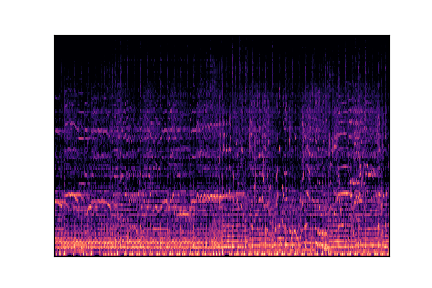

In [50]:
import importlib
import dataset
importlib.reload(dataset)
from dataset import SpectrogramsDataset

dataset = SpectrogramsDataset(spec_dir, features_path)
print(dataset[0][1])
dataset[0][0]